In [4]:
import mkl
mkl.set_num_threads(8)

import time

import pandas as pd
import pickle as pkl
import numpy as np

from scipy.spatial.distance import cdist
import scipy.stats as stats

from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem
from rdkit import DataStructs

from numpy import linalg as LA
from Bio import SeqIO

import pubchempy as pcp

import seaborn as sns

import re

import matplotlib
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

pd.set_option('display.max_rows', 500)

# data

In [46]:
final = pd.read_csv("../2020_09_10/MetaCyc_reactions_correct_direction_nodupe.tsv", sep='\t')

In [2]:
fps = pkl.load(open("/pollard/data/projects/drug_metabolism/SIMMER_files/MC_rxn_fps.p", 'rb'))

In [5]:
tan_ar = pkl.load(open("/pollard/data/projects/drug_metabolism/SIMMER_files/MC_rxn_tanimoto_matrix.p", 'rb'))

In [7]:
id_to_index = pkl.load(open("/pollard/data/projects/drug_metabolism/SIMMER_files/MC_rxn_to_matrix_index_dict.p", 'rb'))

In [9]:
rxn_to_ec = pkl.load(open("/pollard/data/projects/drug_metabolism/SIMMER_files/MC_rxn_ec_dict.p", 'rb'))

# query

In [10]:
dms_df = pd.read_csv("../2020_12_07/dms_plus_uknowns.tsv", sep='\t')

In [11]:
dms_df.shape

(110, 5)

# functions

In [12]:
def run_rxn(row, df):
    sms_l = df.iloc[row,3].split(' // ')
    sms_r = df.iloc[row,4].split(' // ')
    
    smas_l = []
    for sm in sms_l:
        m = Chem.MolFromSmiles(sm.replace('R', '*'))
        sma = Chem.MolToSmarts(m, isomericSmiles=True)
        smas_l.append(sma)
    
    smas_r = []
    for sm in sms_r:
        m = Chem.MolFromSmiles(sm.replace('R', '*'))
        sma = Chem.MolToSmarts(m, isomericSmiles=True)
        smas_r.append(sma)
        
    left = '.'.join(map(str,smas_l))
    right = '.'.join(map(str,smas_r))
    
    rxn = rdChemReactions.ReactionFromSmarts(left + '>>' + right)
    
    return rxn

In [48]:
def do_eigen_decomp(similarities,dump_file,n_factors):
    # perform eigen decomposition

    print("Starting eigen decomp...")

    D, V = LA.eigh(np.array(similarities))
    
    for f in n_factors:
        V_fin = V[:,-int(f):] #or V[:,-8:] for top vals #specify dimensionality reduction
        D_fin = D[-int(f):] #or D[:,-8:] for top vals #specify dimensionality reduction
        #for i in range(len(D_fin)):
        #    if D_fin[i] < .000001:
        #        D_fin[i] = 0.0
        D_half = np.sqrt(D_fin)
        D_half = np.diag(D_half)
        X_mol = np.dot(V_fin,D_half)
        print("Finished eigen decomp for " + str(f) + " factors")
        pkl.dump(X_mol, open(str(dump_file) + str(f) + '_factors.p', "wb"))

In [42]:
# to handle the NILS while building list comprehension
def catch(f):
    try:
        return f
    except IndexError:
        return 'NIL'

In [43]:
def find_closest_rxns(query_id, X_mol):
    dists = {}
    vec = id_to_index[query_id]
    for i in range(len(X_mol)):
        dist = np.linalg.norm(X_mol[vec] - X_mol[i])
        dists[i] = dist
    
    s_dists = sorted(dists.items(),key=lambda x:x[1])
    
    results = []
    for ind, dist in s_dists:
        results.append([list(id_to_index.keys())[list(id_to_index.values()).index(ind)], str(dist)])
        
    [results.remove(result) for result in results if query_id in result]
    
    return results

In [49]:
def calc_odds_ratio(query, fp_type_tanimotos, ec_level):
    
    df_result = pd.DataFrame(
    [catch([rxn[0],rxn[1], '.'.join(rxn_to_ec[rxn[0]].split('.')[:ec_level])]) for rxn in find_closest_rxns(query, fp_type_tanimotos)]
    )
    
    #df_result = df_result[~df_result[0].str.startswith('DM')]
    df_result = df_result.loc[df_result[0]!=query]
    df_result = df_result.loc[df_result[2]!='DM']
    df_result = df_result.iloc[:25,:]
    df_result = df_result.loc[df_result[2]!='NIL']
    
    best_result = []
    for ec in df_result[2].unique():
    
        x1 = df_result.iloc[:25,:].groupby(2).count().iloc[df_result.iloc[:25,:].groupby(2).count().index.get_loc(ec)][0]
        x2 = 25-x1
        tot_ec_rxns = df_result.groupby(2).count().iloc[df_result.groupby(2).count().index.get_loc(ec)][0]
        x3 = tot_ec_rxns - x1
        x4 = 9024-tot_ec_rxns-x2
    
        table = np.array([[(x1+1), (x2+1)],[(x3+1), (x4+1)]])
    
        #this pvalue is the same as doing a survival function (1-cdf of hypergeometric)
        oddsratio, pvalue = stats.fisher_exact(table)
        best_result.append([query, ec, df_result.loc[df_result[2]==ec][1].min(), oddsratio, pvalue])
    
    best_result_df = pd.DataFrame(best_result)
    best_result_df.columns = ['query', 'predicted_EC', 'min_euc', 'OR', 'p_value']
    
    return best_result_df.loc[best_result_df['p_value']<0.05].sort_values(by='min_euc')

In [99]:
def make_ec_plot(DM):
    sns.set_style("white")
    df1 = pd.DataFrame(find_closest_rxns(DM, X_mol))
    
    df1['ec'] = [rxn_to_ec[rxn].split('.')[0] for rxn in df1[0]]
    df1.columns = ['rxn', 'distance', 'ec']
    skip = ['DM', 'NIL', 'missing']
    plot_df = df1[~df1['ec'].isin(skip)]
    plot_df['distance'] = plot_df['distance'].astype('float')
    

    g = sns.FacetGrid(plot_df, hue="ec", height=8.27, aspect=11.7/8.27, palette='Set2')
    g = g.map(sns.distplot, "distance",  hist=True, rug=True, kde=False)
    
    plt.legend()
    plt.title((DM), fontsize=20)
    plt.tick_params(labelsize=12)
    plt.xlabel('Euclidean distance', fontsize=20)
    plt.ylabel('Count', fontsize=20)
    
    plt.show()

# run a query

## query fps

In [14]:
t0 = time.time()
for i in range(len(dms_df)):
    rxn = run_rxn(i, dms_df)
    fp = Chem.rdChemReactions.CreateDifferenceFingerprintForReaction(rxn)
    fps.append(fp)
t1 = time.time()

print(t1-t0)
len(fps)

0.1570296287536621


9024

## tanimoto similarity

In [18]:
metacyc_fps = fps[:8914]
dms_fps = fps[8914:]

tot_fps = metacyc_fps+dms_fps

In [22]:
t0 = time.time()
tan_ar_dm = []
for i in range(len(dms_fps)):
    tan = DataStructs.cDataStructs.BulkTanimotoSimilarity(dms_fps[i], tot_fps)
    tan_ar_dm.append(tan)
    if len(tan_ar_dm)%1000 == 0:
        print(len(tan_ar_dm))
t1 = time.time()

print(t1-t0)

4.78749942779541


In [26]:
tot_array = np.append(np.array(tan_ar),np.array(tan_ar_dm)[:,:8914], axis=0)

tot_array_final = np.append(tot_array, np.array(tan_ar_dm).T, axis=1)

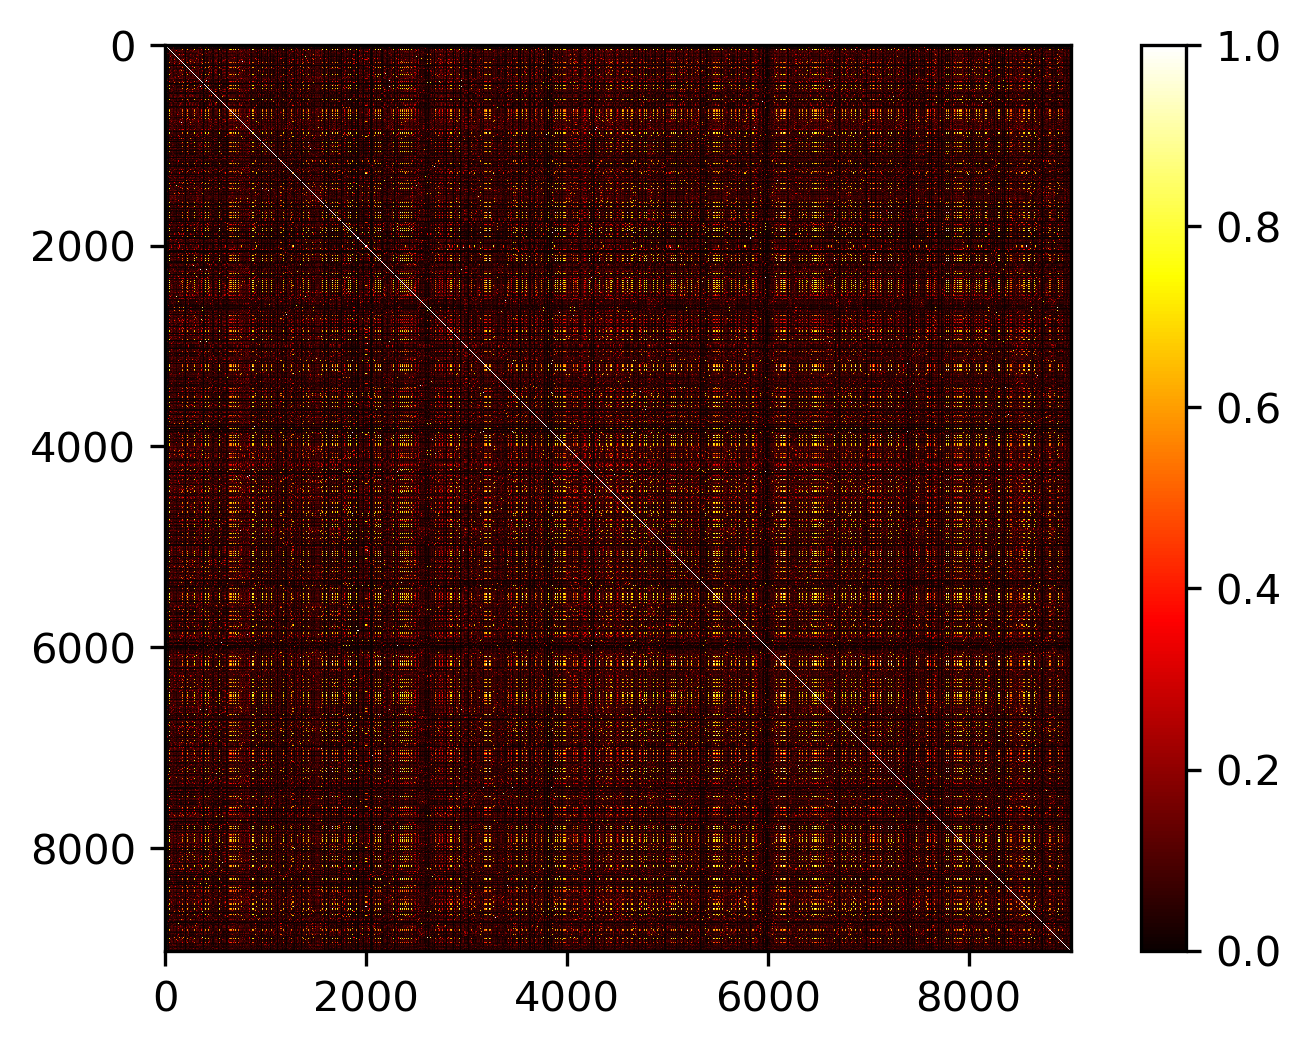

In [28]:
plt.imshow(tot_array_final, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## eigen

In [ ]:
do_eigen_decomp(np.array(tan_ar), "./new_rxns", [8])

## EC predictions and closest rxns

In [29]:
X_mol = tot_array_final

In [32]:
for i in range(len(dms_df)):
    id_to_index[dms_df.iloc[i,0]] = i+8914

In [39]:
for i in range(len(dms_df)):
    rxn_to_ec[dms_df.iloc[i,0]] = 'DM'

['DM10' '1' '2.5238980025516238' 6187.5 1.9318670073325117e-28]
[['DM10' '1.1' '2.5238980025516238' 720.0 2.5794119072782918e-05]
 ['DM10' '1.5' '2.6293516534760273' 1565.2173913043478
  3.165879645647123e-10]
 ['DM10' '1.3' '2.7729698327107246' 1125.0 9.524446403071964e-08]
 ['DM10' '1.14' '3.2281582973101814' 1565.2173913043478
  3.165879645647123e-10]
 ['DM10' '1.13' '3.4063582101944996' 720.0 2.5794119072782918e-05]]
[['DM10' '1.1.98' '2.5238980025516238' 720.0 2.5794119072782918e-05]
 ['DM10' '1.5.98' '2.6293516534760273' 1565.2173913043478
  3.165879645647123e-10]
 ['DM10' '1.3.8' '2.7729698327107246' 1125.0 9.524446403071964e-08]
 ['DM10' '1.14.19' '3.2281582973101814' 1565.2173913043478
  3.165879645647123e-10]
 ['DM10' '1.13.11' '3.4063582101944996' 720.0 2.5794119072782918e-05]]
RXN-11080 1.1.98.3


RDKit WARNING: [14:06:36] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [14:06:36] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [14:06:36] Explicit valence for atom # 7 N, 4, is greater than permitted


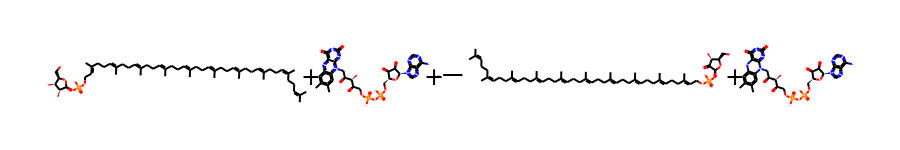

In [100]:
closest_rxn = find_closest_rxns("DM10", X_mol)[0][0]
closest_ec = rxn_to_ec[closest_rxn]

ec1df = calc_odds_ratio('DM10', X_mol, 1).iloc[0,:]
print(ec1df.values)
ec1 = ec1df[1]
ec2df = calc_odds_ratio('DM10', X_mol, 2)
print(ec2df.loc[ec2df['predicted_EC'].str.startswith(ec1)].values)
ec3df = calc_odds_ratio('DM10', X_mol, 3)

print(ec3df.loc[ec3df['predicted_EC'].str.startswith(ec1)].values)

print(closest_rxn, closest_ec)
run_rxn(final.loc[final['reaction']==closest_rxn].index[0],final)

# distributions

/pollard/home/abustion/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


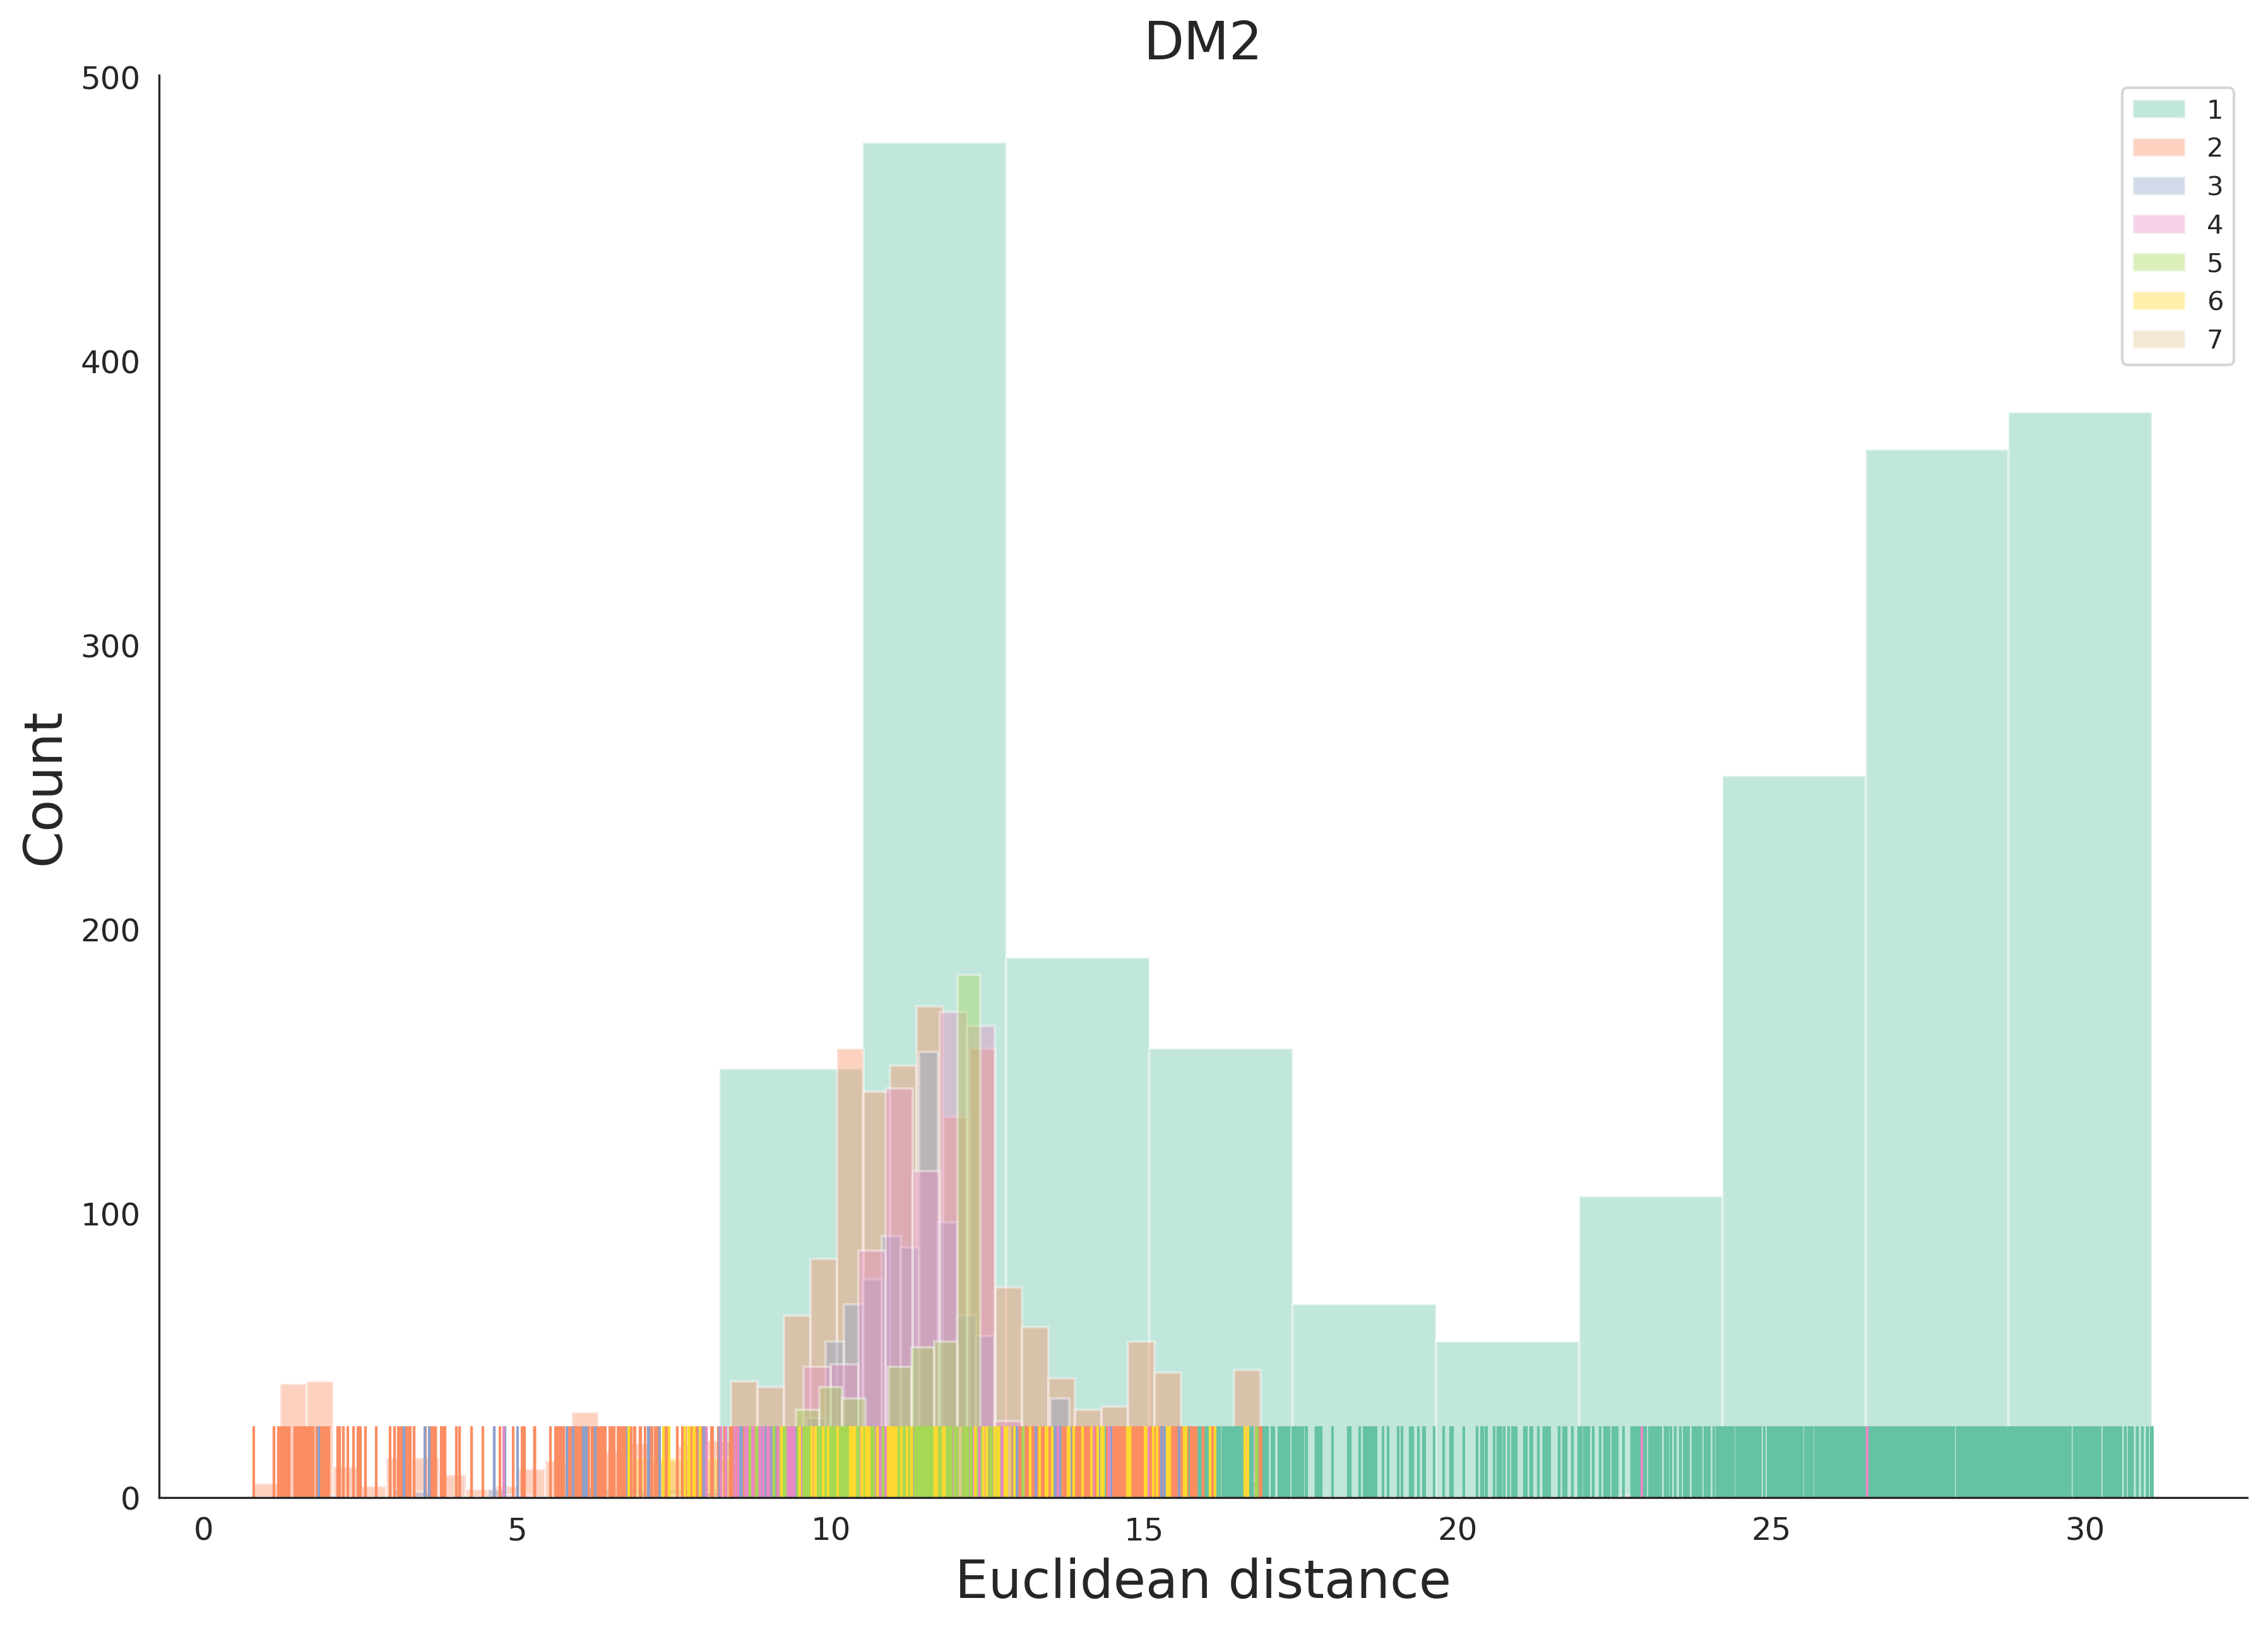

In [98]:
make_ec_plot("DM2")